# MNIST Digit Recognizer - Simple Neural Network Classification

**Authors: Clement, Calvin, Tilova**

---

Welcome to the second notebook by **Tequila Chicas**! We will be classifying images of hand written numbers to their corresponding digits. This project follows the guidelines and uses the data set provide from the Kaggle Competition [here](https://www.kaggle.com/competitions/digit-recognizer/overview). 

## Introduction  

In this notebook we will be fitting the dataset in a simple neural network to see how well we can predict the digits of the MNIST Dataset.

<a id = 'toc'></a>
    
## Table of Contents
---
1. [Simple Neural Network](#simple)

**Importing Libraries**

In [59]:
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Train_Test_Split
from sklearn.model_selection import train_test_split

# Scaling
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import accuracy_score

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Progress bar from tqdm
from tqdm.notebook import trange
from tqdm.notebook import tnrange

# ignores the filter warnings
import warnings
warnings.filterwarnings('ignore')

<a id = 'simple'></a>
### 1. Simple Neural Network
---
Loading the test and train set CSVs files.

In [60]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train.shape, df_test.shape

((42000, 785), (28000, 784))

We need to set our independent (X) and dependent (y) variables as `numpy arrays` from the dataset.

In [61]:
X = df_train.iloc[:, 1:].to_numpy()
y = df_train.iloc[:, 0].to_numpy()

# sanity check
print(X.shape, y.shape)

(42000, 784) (42000,)


We will perform a **train_test_split()** to split our dataset into train and validation sets.
- Validation size of 25% of the data.
- Stratify=y to make sure distribution of the classes remain the same in both training and validation set.

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y)
X_train.shape, y_train.shape

((31500, 784), (31500,))

We can start by implementing a simple `linear` network.
- Since it's linear, we would obtain better results when scaling the data.

In [63]:
# instantiate standard scaler
ss = StandardScaler()

# fit and transform training
X_train = ss.fit_transform(X_train)

# ONLY transform X_val
X_val = ss.transform(X_val)

Now we need to convert the 1-D `arrays` into torch `tensors`
- Using float32 to cut down memory usage
- Using torch.long for classification labels.

In [64]:
# Independent Variables
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)

# Dependent Variable
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Sanity Check
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

torch.Size([31500, 784]) torch.Size([31500]) torch.Size([10500, 784]) torch.Size([10500])


In [8]:
# Simple neural net layers
simple_neural_net = nn.Sequential(
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 50),
    nn.ReLU(),
    nn.Linear(50, 10)
    )
simple_neural_net

Sequential(
  (0): Linear(in_features=784, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

In [9]:
# Creating a single row
single_row = X_train[[0], :]
single_target = y_train[[0]]


# Instantiate Optimizer
optimizer = torch.optim.SGD(simple_neural_net.parameters(), lr=0.01)

#### Forward pass ####
output_values = simple_neural_net(single_row)

# Cross Entropy Loss
cross_entropy_loss = nn.CrossEntropyLoss()
loss = cross_entropy_loss(output_values, single_target)

#### Backward pass ####
loss.backward()

# Update Weights
optimizer.step()

# New Outputs
new_output = simple_neural_net(single_row)
new_loss = cross_entropy_loss(new_output, single_target)

# Comparing old and new loss
print(f"Old loss: {loss}\nNew loss: {new_loss}")

Old loss: 2.3218276500701904
New loss: 2.239776372909546


Now let's implement our PyTorch model through object oriented programming. We make sure to define a class that inherits from the PyTorch `module` class. 

In [443]:
class SimpleNN(nn.Module):
    """Basic multi-layer architecture."""

    def __init__(self):
        """Define the main components of the network"""
        super(SimpleNN, self).__init__()

        self.neural_net = nn.Sequential(
            nn.Linear(784, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64, 10)
            )
    
    def forward(self, x):
        """Perform forward pass."""
        
        output = self.neural_net(x)
        
        return output

    def predict(self, x):
        '''
        The class based interface allows you
        add your own functionality, like a familiar
        .predict method we all know and love
        '''

        # Predict class probabilities
        predictions = self.forward(x)

        # Find highest class prediction, notice we don't need to convert to
        # probabilities to do hard predictions, we can simply choose the
        # highest values
        hard_class_predictions = torch.argmax(predictions, dim=1)

        return hard_class_predictions

In [457]:
####### Setting batch size #######
batch_size = 256 

# Shuffle training set
training_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)

# Don't shuffle validation set
validation_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size, shuffle=False)

In [463]:
####### Parameters #######
lr = 0.0001
# momentum = 0.9

# Instantiate the model, the loss criterion, and the optimizer
NN_model = SimpleNN()

cross_entropy_loss = nn.CrossEntropyLoss() # this includes the softmax
optimizer = torch.optim.Adam(NN_model.parameters(), lr=lr, weight_decay=0.01)

In [464]:
### COMMON PYTORCH RECIPE FOR TRAINING A NETWORK ###

epoch_number = 0

total_train_loss = []
total_val_loss = []

# Now run for 25 epochs
for epoch in trange(40, desc="Total epochs: "):
    print('EPOCH {}:'.format(epoch_number + 1))
    
    ##### Training #####
    running_loss = 0
    last_loss = 0
    
    NN_model.train(True)
    
    # Compute 
    for i, data in enumerate(training_loader):
        
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = NN_model(inputs)

        # Compute the loss and its gradients
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data 
        running_loss += loss.item()

    total_train_loss.append(running_loss)
    
    ##### Validation #####
    running_vloss = 0.0
    
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    NN_model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata
            voutputs = NN_model(vinputs)
            vloss = cross_entropy_loss(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    total_val_loss.append(avg_vloss)
    
    epoch_number += 1
    
    print('LOSS train {} valid {}'.format(running_loss, avg_vloss))

print(f"Optimization ended successfully")

Total epochs:   0%|          | 0/40 [00:00<?, ?it/s]

EPOCH 1:
LOSS train 230.02122569084167 valid 9.813517570495605
EPOCH 2:
LOSS train 163.1432912349701 valid 10.2577543258667
EPOCH 3:
LOSS train 131.40377753973007 valid 13.790443420410156
EPOCH 4:
LOSS train 111.55551546812057 valid 13.550986289978027
EPOCH 5:
LOSS train 97.43248748779297 valid 14.059492111206055
EPOCH 6:
LOSS train 86.32685202360153 valid 10.994544982910156
EPOCH 7:
LOSS train 78.57014018297195 valid 11.589845657348633
EPOCH 8:
LOSS train 71.40386095643044 valid 10.031144142150879
EPOCH 9:
LOSS train 67.02849105000496 valid 8.446317672729492
EPOCH 10:
LOSS train 62.77581503987312 valid 7.852224349975586
EPOCH 11:
LOSS train 59.06021973490715 valid 7.0515828132629395
EPOCH 12:
LOSS train 56.849258214235306 valid 5.80142068862915
EPOCH 13:
LOSS train 54.12352627515793 valid 4.808329105377197
EPOCH 14:
LOSS train 51.300347954034805 valid 4.897988319396973
EPOCH 15:
LOSS train 49.053183645009995 valid 4.616078853607178
EPOCH 16:
LOSS train 46.83003228902817 valid 4.115509

In [465]:
# Make predictions
binary_classification = NN_model.predict(X_train)

# Calculate the score on the test set
accuracy = accuracy_score(y_train, binary_classification)
print(f"Accuracy score on train set: {round(accuracy * 100, 2)}%")

Accuracy score on train set: 98.2%


In [466]:
# Make predictions
binary_classification = NN_model.predict(X_val)

# Calculate the score on the test set
accuracy = accuracy_score(y_val, binary_classification)
print(f"Accuracy score on test set: {round(accuracy * 100, 2)}%")

Accuracy score on test set: 95.25%


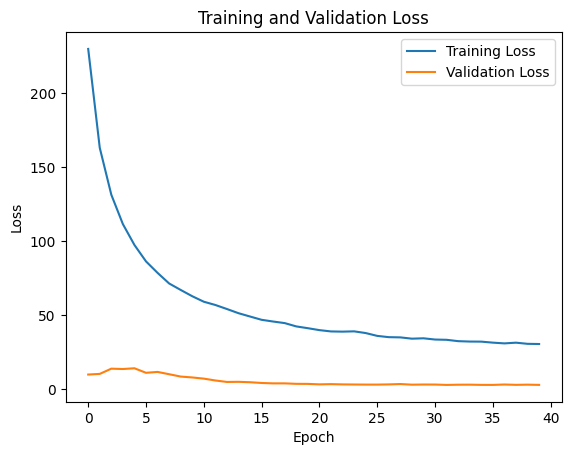

In [468]:
plt.figure()
plt.plot(total_train_loss, label="Training Loss")
plt.plot(total_val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

> Validation loss is lower than training loss possibly because of our dropout layers.